In [1]:
import os
import io
import sys

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from scipy.spatial import distance

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import TfidfVectorizer

import scipy.io as sio

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

### Load Trade barriers definitions

In [2]:
Tariff_def, Nontarrif_def = {}, {}

Files = []
basepath = 'C:/Users/user/Desktop/Trade barrier/Barriers definition/Tariff/'
for entry in os.listdir(basepath):
    if os.path.isfile(os.path.join(basepath, entry)):
        Files.append(entry[:-4])
        Tariff_def[entry[:-4]] = {'Text':[], 'Vec':[]}
        
print(Files)        
for File in Files:
    with open(basepath+File+'.txt') as f:
         Tariff_def[File]['Text'] = f.read().splitlines()


Files = []
basepath = 'C:/Users/user/Desktop/Trade barrier/Barriers definition/NonTariff/'
for entry in os.listdir(basepath):
    if os.path.isfile(os.path.join(basepath, entry)):
        Files.append(entry[:-4])
        Nontarrif_def[entry[:-4]] = {'Text':[], 'Vec':[]}

print(Files)        
for File in Files:
    with open(basepath+File+'.txt') as f:
         Nontarrif_def[File]['Text'] = f.read().splitlines()

['Direction', 'Distribution points', 'Import restraints', 'Purpose', 'Rates', 'Time length']
['Customs and entry procedures', 'Financial control', 'Government participation in trade', 'Product requirements', 'Quotas']


In [3]:
with open('Russian_Sentiments.pkl','rb') as pickle_in:
     Texts_Sentiments = pickle.load(pickle_in)
        
Texts = Texts_Sentiments['Negative']

In [4]:
len(Texts)

1164

1451

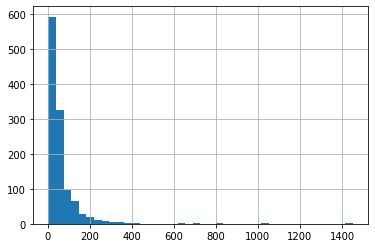

In [5]:
seq_len = [len(i.split()) for i in Texts]

pd.Series(seq_len).hist(bins = 40)
max(seq_len)

In [6]:
# specify GPU device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'GeForce GTX 1070'

In [7]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: GeForce GTX 1070


In [8]:
def remove_stopwords(texts):
    return [' '.join([word for word in doc.lower().split() if word not in stopwords.words('english')]) for doc in texts]

### Import BERT Model and BERT Tokenizer

In [9]:
def Bert_Features(Data, max_seq_len, batch_size = 16):
    device = torch.device("cuda")
    
    # import BERT-base pretrained model
    bert = AutoModel.from_pretrained('bert-base-uncased')
    # Load the BERT tokenizer
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

    bert = bert.to(device)

    Tokens_Data = tokenizer.batch_encode_plus(Data, max_length = max_seq_len,
             padding=True, truncation=True,return_token_type_ids=False)

    Data_seq = torch.tensor(Tokens_Data['input_ids']).to(device)
    Data_mask = torch.tensor(Tokens_Data['attention_mask']).to(device)

    train_data = TensorDataset(Data_seq, Data_mask)
    train_sampler = SequentialSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler,\
                              batch_size=batch_size)
    Features = []

    for step, batch in enumerate(train_dataloader):   
        batch = [r.to(device) for r in batch]
        sent_id, mask = batch
        _, Feature_Vec = bert(sent_id, mask)

        Feature_Vec = Feature_Vec.detach().cpu().numpy()        
        Features.append(Feature_Vec)
    
    Features  = np.concatenate(Features, axis=0)
    return Features

In [10]:
torch.cuda.empty_cache()

batch_size = 16
max_seq_len = 200
Texts = remove_stopwords(Texts)
Features = Bert_Features(Texts, max_seq_len)

torch.cuda.empty_cache()

In [11]:
Features.shape

(1164, 768)

In [12]:
for barrier in Tariff_def.keys():
    Tariff_def[barrier]['Vec'] = Bert_Features(remove_stopwords(Tariff_def[barrier]['Text']), max_seq_len)

for barrier in Nontarrif_def.keys():
    Nontarrif_def[barrier]['Vec'] = Bert_Features(remove_stopwords(Nontarrif_def[barrier]['Text']), max_seq_len)

In [13]:
#https://danushka.net/lect/dm/Numpy-basics.html
Similarities = []
for Feature in Features:
    scores = []
    for barrier in Tariff_def.keys():
        MaxSim ,Sim = 0, 0
        for Vec in Tariff_def[barrier]['Vec']:
            Sim = round(1-distance.cosine(Feature, Vec), 2)
            if MaxSim < Sim:
                MaxSim = Sim
        scores.append(MaxSim)
        
    for barrier in Nontarrif_def.keys():
        MaxSim ,Sim = 0, 0
        for Vec in Nontarrif_def[barrier]['Vec']:
            Sim = round(1-distance.cosine(Feature, Vec), 2)
            if MaxSim < Sim:
                MaxSim = Sim
        scores.append(MaxSim)
    Similarities.append(scores)

In [14]:
Similarities[0:10],Texts[2]

([[0.94, 0.96, 0.96, 0.95, 0.97, 0.98, 0.96, 0.92, 0.95, 0.94, 0.92],
  [0.99, 0.99, 0.99, 0.99, 0.98, 0.97, 0.97, 0.97, 0.98, 0.97, 0.95],
  [0.94, 0.97, 0.96, 0.96, 0.98, 0.98, 0.97, 0.93, 0.96, 0.95, 0.93],
  [0.83, 0.88, 0.86, 0.85, 0.92, 0.92, 0.9, 0.8, 0.89, 0.84, 0.82],
  [0.95, 0.96, 0.94, 0.95, 0.96, 0.96, 0.93, 0.91, 0.97, 0.92, 0.89],
  [0.99, 0.99, 0.99, 0.99, 0.97, 0.97, 0.97, 0.96, 0.98, 0.97, 0.94],
  [0.91, 0.95, 0.94, 0.93, 0.96, 0.97, 0.94, 0.9, 0.95, 0.9, 0.89],
  [0.6, 0.66, 0.62, 0.62, 0.7, 0.7, 0.62, 0.53, 0.82, 0.54, 0.5],
  [0.89, 0.92, 0.9, 0.9, 0.93, 0.93, 0.88, 0.84, 0.95, 0.85, 0.82],
  [0.98, 0.99, 0.98, 0.98, 0.98, 0.97, 0.97, 0.95, 0.97, 0.97, 0.94]],
 'even survive cost 800 rubles per square meter cost price pvc reinforced swiing pools pvc thickne 15 also geotextile 50 rubles material without work pvc welding')

In [15]:
out = np.concatenate(Similarities).ravel()
len(Similarities), out.shape

(1164, (12804,))

In [16]:
from statistics import mode
from collections import Counter

out = np.array(Similarities)
Threshold = []
for i in range(0,11):
    #print(str(i),np.min(out[:,i]), np.max(out[:,i]), round(np.std(out[:,i]),2))#, mode(out[:,i]))
    print(str(i),np.min(out[:,i]), np.max(out[:,i]), round(np.std(out[:,i]),2), Counter(out[:,i]).most_common(1)[0][0])
    Threshold.append(Counter(out[:,i]).most_common(1)[0][0])

0 0.34 0.99 0.12 0.89
1 0.4 0.99 0.11 0.96
2 0.37 0.99 0.11 0.94
3 0.36 0.99 0.12 0.94
4 0.46 0.98 0.09 0.96
5 0.47 0.98 0.09 0.96
6 0.38 0.99 0.11 0.93
7 0.27 0.98 0.13 0.92
8 0.64 0.99 0.06 0.95
9 0.28 0.98 0.13 0.87
10 0.24 0.97 0.13 0.9


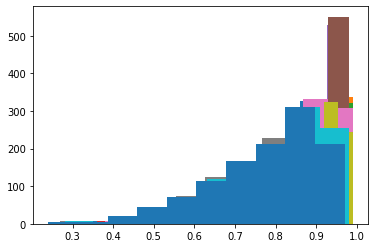

In [17]:
for i in range(0,11):
     n, bins, patches = plt.hist(out[:,i])
plt.show()

In [18]:
Detected_Barriers = out.copy()

for A in Detected_Barriers:
    for i in range(0,11):
        if A[i]>=Threshold[i]:
            A[i]=1
        else:
            A[i]=0
out[10], Detected_Barriers[10]

(array([0.89, 0.91, 0.89, 0.89, 0.94, 0.92, 0.9 , 0.83, 0.94, 0.86, 0.83]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [19]:
Tariff_keys = ['Direction', 'Distribution points', 'Import restraints', 'Purpose', 'Rates', 'Time length']
NonTariff_keys = ['Customs and entry \n procedures', 'Financial control', 'Government participation \n in trade', 'Product requirements', 'Quotas']
Tariff = {}
NonTariff = {}
for i in range(0,11):
    print(str(i),np.sum(Detected_Barriers[:,i]), int(round((np.sum(Detected_Barriers[:,i])/1164)*100,0)))
    if i < 6:
        Tariff[Tariff_keys[i]] = int(round((np.sum(Detected_Barriers[:,i])/1164)*100,0))
    else:
        NonTariff[NonTariff_keys[i-6]] = int(round((np.sum(Detected_Barriers[:,i])/1164)*100,0))
        

0 440.0 38
1 212.0 18
2 268.0 23
3 253.0 22
4 289.0 25
5 307.0 26
6 309.0 27
7 162.0 14
8 344.0 30
9 440.0 38
10 212.0 18


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


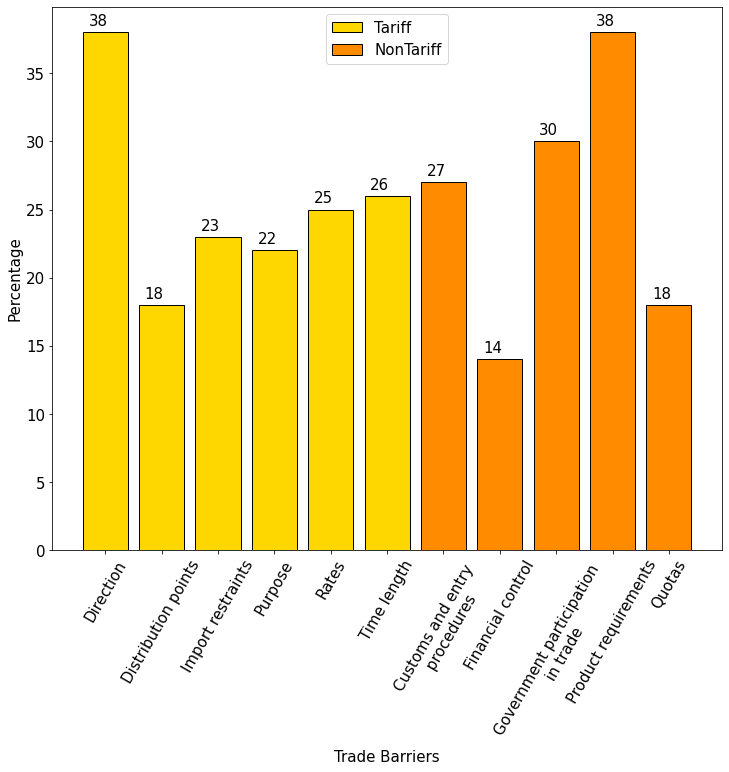

In [20]:
fig, ax = plt.subplots(figsize=(12,10))

Barrier_names = Tariff_keys + NonTariff_keys
Barrier_proportion = list(Tariff.values())+list(NonTariff.values())

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel('Percentage',fontsize=15)
ax.set_xlabel("Trade Barriers",fontsize=15)
#ax.bar(Barrier_names, Barrier_proportion)

T = ax.bar(Tariff_keys, Tariff.values(), color = 'gold', edgecolor='black', label="Tariff")
NT = ax.bar(NonTariff_keys, NonTariff.values(), color = 'darkorange', edgecolor='black', label="NonTariff")

for index,data in enumerate(Barrier_proportion):
    ax.text(x=index-0.3 , y =data+0.5 , s=f"{data}" , fontdict=dict(fontsize=15))
plt.xticks(rotation=60)

plt.legend(handles=[T, NT], prop={'size': 15})
fig.savefig('Russian_Barriers.eps', format="eps", bbox_inches = 'tight')#, dpi=1000
plt.show()

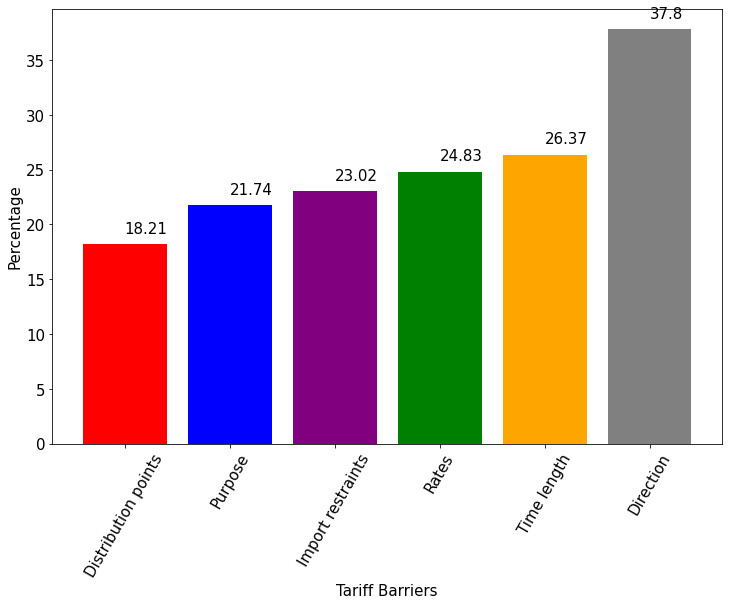

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
Sorted_Tariff = {k: v for k, v in sorted(Tariff.items(), key=lambda item: item[1])}
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel('Percentage',fontsize=15)
ax.set_xlabel("Tariff Barriers",fontsize=15)
ax.bar(Sorted_Tariff.keys(), Sorted_Tariff.values(), color=['red', 'blue', 'purple', 'green', 'orange', 'gray'])
for index,data in enumerate(Sorted_Tariff.values()):
    ax.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=15))
plt.xticks(rotation=60)
fig.savefig('Russian_Tariff_Barriers.eps', format="eps")

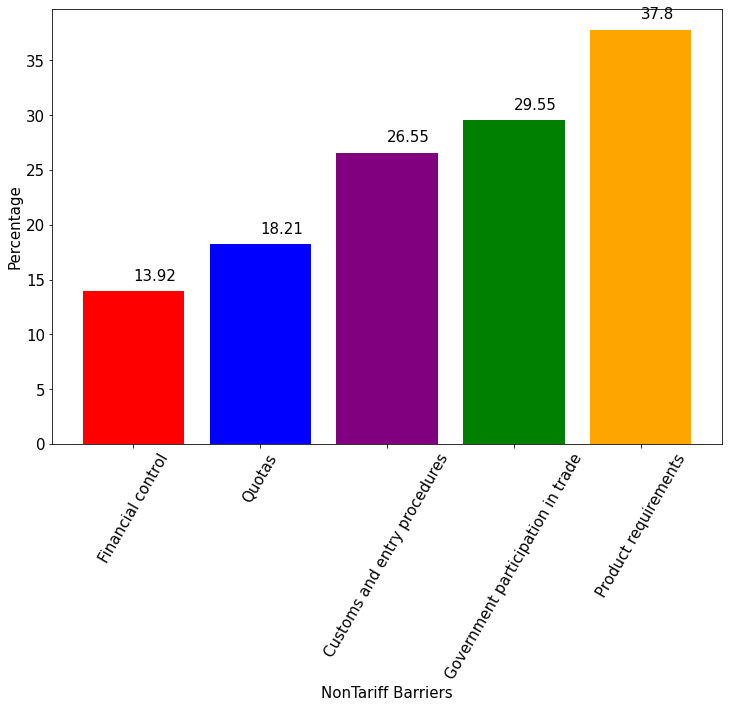

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
Sorted_NonTariff = {k: v for k, v in sorted(NonTariff.items(), key=lambda item: item[1])}
my_colors = 'rgbkymc'
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel('Percentage',fontsize=15)
ax.set_xlabel("NonTariff Barriers",fontsize=15)
ax.bar(Sorted_NonTariff.keys(), Sorted_NonTariff.values(), color=['red', 'blue', 'purple', 'green', 'orange'])

for index,data in enumerate(Sorted_NonTariff.values()):
    ax.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=15))
plt.xticks(rotation=60)
fig.savefig('Russian_NonTariff_Barriers.eps', format="eps")

In [21]:
Tariff_Text = dict.fromkeys(Tariff_keys , [])
NonTariff_Text = dict.fromkeys(NonTariff_keys , [])

for i in range(0,len(Texts)):
    for j in range(0,6):
        if Detected_Barriers[i][j] == 1.:
            Tariff_Text[Tariff_keys[j]].append(Texts[i])
    for j in range(0,5):
        if Detected_Barriers[i][j] == 1.:
            NonTariff_Text[NonTariff_keys[j]].append(Texts[i])

for j in range(0,6):
    Tariff_Text[Tariff_keys[j]] = list(set(Tariff_Text[Tariff_keys[j]]))
for j in range(0,5):
    NonTariff_Text[NonTariff_keys[j]] = list(set(NonTariff_Text[NonTariff_keys[j]]))

In [38]:
def Text_Clustering(List, N):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(List)

    vocab_inverted = {}
    for word, column_index in vectorizer.vocabulary_.items():
        vocab_inverted[column_index] = word

    clusterer = KMeans(n_clusters=N, init='k-means++', max_iter=1000, n_init=1)
    clustered_docs = clusterer.fit(X)
    
    Text_Centers = []
    for i, center in enumerate(clusterer.cluster_centers_):
        center_index = [(x, i) for i, x in enumerate(center)]
        topn = sorted(center_index, reverse=True)[:7]
        Text_Centers.append(' '.join([vocab_inverted[i] for _, i in topn]))
    return Text_Centers

In [41]:
Tariff_Cluster = dict.fromkeys(Tariff_keys , [])
NonTariff_Cluster = dict.fromkeys(NonTariff_keys , [])

for j in range(0,6):
    Tariff_Cluster[Tariff_keys[j]] = Text_Clustering(Tariff_Text[Tariff_keys[j]], 5)
    
for j in range(0,5):
    NonTariff_Cluster[NonTariff_keys[j]] = Text_Clustering(NonTariff_Text[NonTariff_keys[j]], 5)

In [43]:
for key in Tariff_Cluster.keys():
    print('_________________'+key+'_________________')
    for text in Tariff_Cluster[key]:
        print(text)

_________________Direction_________________
fence line lot pond land sides topic
work time long video maybe day pond
thing main case compreor pond poible meters
fish source pond quotation problem winter thing
matter opetion principle air pipe know thing
_________________Distribution points_________________
thing main fence line source look opetion
meters day work 30 hour level 20
pump siphon try ice work old principle
fish pond matter understand thing pctice time
work video rest rubles need maybe thousand
_________________Import restraints_________________
fish pond understand make matter different work
work need maybe fish time video year
poible right air work way really pond
needed work reservoir level 30 according land
thing main source quotation fish people pond
_________________Purpose_________________
work fish maybe video need time rest
thing main matter fish fishing know fact
source opetion line principle quotation fish problem
pipe siphon din pond air tee tilt
pond meters fenc

In [44]:
for key in NonTariff_Cluster.keys():
    print('_________________'+key+'_________________')
    for text in NonTariff_Cluster[key]:
        print(text)

_________________Customs and entry 
 procedures_________________
thing main fish line fence opetion time
work pond source winter reservoir rest meters
pump company compreor work use fish chinese
matter organic years fact oxygen pond fish
know maybe video work look fish kind
_________________Financial control_________________
tell face addre director event region right
fish pond fence line main case thing
work thing main time pump long maybe
meters source hectares know 20 thing work
matter need fish work source pond organic
_________________Government participation 
 in trade_________________
principle opetion matter company pipe air know
work fish pond line year source time
right need little work small fish use
meters 100 say bar 20 pond matter
thing main money fish launch suer think
_________________Product requirements_________________
work video line maybe fence opetion time
thing main matter pctice organic fact money
fish need work year little farm source
pond fish work poible rese

### Unsupervised Text Clustering

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MeanShift
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

def Unsupervised_Text_Clustering(List):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(List)

#    vocab_inverted = {}
#    for word, column_index in vectorizer.vocabulary_.items():
#        vocab_inverted[column_index] = word

    clustering = MeanShift().fit(X.toarray())
    labels = clustering.labels_
    
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    print('number of clusters:', n_clusters_)

    centers = clustering.cluster_centers_
    print(len(cluster_centers))
    
#    Text_Centers = []
#    for i, center in enumerate(centers):
#        center_index = [(x, i) for i, x in enumerate(center)]
#        topn = sorted(center_index, reverse=True)[:7]
#        Text_Centers.append(' '.join([vocab_inverted[i] for _, i in topn]))
#    return Text_Centers

#Text_Centers = 
Unsupervised_Text_Clustering(Texts)
Text_Centers

In [33]:
#https://stackoverflow.com/questions/46183760/document-clustering-using-mean-shift

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import MeanShift
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

pipeline = Pipeline(
steps=[
    ('tfidf', CountVectorizer()),
    ('trans', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
    ('clust', MeanShift())
  ])

pipeline.fit(Texts)
pipeline.named_steps['clust'].labels_

result = [(label,doc) for doc,label in zip(Texts, pipeline.named_steps['clust'].labels_)]

for label,doc in sorted(result):
    print(label, doc)

0 1 15kw 500 rubles opete agricultul sector 2 fence farm pond 3 make sauna agricultul farm works fence need
0 11 fish dwing need dw legs put legs easiest way fix windmill fe know fix stretcher even function turning around axis direct jet strictly neceary place weak point antifreeze
0 11 fish heating rises pours dozen barrels sucking cold pond heats night poured pond aeted time astronauts work orbit
0 11 fish kind matter boards covered way tell something padding polyester
0 11 fish see slopes already collected work rode slopes made except side river
0 11 fish tde worms afid
0 11 region write maybe work together
0 11132009 1810 know concern order management brings tried add links see products work
0 11ryba ares 400 sq meters day yesterday caught little evening work 25 hours caught little 500 gs three 400 gs corn banduelle pearl barley honey
0 11ryba petya see links technical details prices offer take ready made factory equipment although principle opetion installations completely clear a

In [32]:
print(np.unique(pipeline.named_steps['clust'].labels_))
result = [(label,doc) for doc,label in zip(Texts, pipeline.named_steps['clust'].labels_)]

for label,doc in sorted(result):
    print(label, doc)

[0]
0 1 15kw 500 rubles opete agricultul sector 2 fence farm pond 3 make sauna agricultul farm works fence need
0 11 fish dwing need dw legs put legs easiest way fix windmill fe know fix stretcher even function turning around axis direct jet strictly neceary place weak point antifreeze
0 11 fish heating rises pours dozen barrels sucking cold pond heats night poured pond aeted time astronauts work orbit
0 11 fish kind matter boards covered way tell something padding polyester
0 11 fish may khrushch also brought manure stan contained rhino larvae times larger may ones almost 10 length deer beetle faces even larger deer beetle red book udmurtia still stnge thing matter much tried catch horse bite
0 11 fish see slopes already collected work rode slopes made except side river
0 11 fish tde worms afid
0 11 region write maybe work together
0 11132009 1810 know concern order management brings tried add links see products work
0 11ryba ares 400 sq meters day yesterday caught little evening work

### Text Generation GPT-2